
Our dataset consists of clinical data from patients who entered the hospital complaining of chest pain ("angina") during exercise.  The information collected includes:

* `age` : Age of the patient

* `sex` : Sex of the patient

* `cp` : Chest Pain type

    + Value 0: asymptomatic
    + Value 1: typical angina
    + Value 2: atypical angina
    + Value 3: non-anginal pain
   
    
* `trtbps` : resting blood pressure (in mm Hg)

* `chol` : cholesterol in mg/dl fetched via BMI sensor

* `restecg` : resting electrocardiographic results

    + Value 0: normal
    + Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    + Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

* `thalach` : maximum heart rate achieved during exercise

* `output` : the doctor's diagnosis of whether the patient is at risk for a heart attack
    + 0 = not at risk of heart attack
    + 1 = at risk of heart attack

In [1]:
## library imports here
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, confusion_matrix, accuracy_score, recall_score, precision_score, auc, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from plotnine import *
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from plotnine import *
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from plotnine import *
from sklearn.metrics import make_scorer, cohen_kappa_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC

In [2]:
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")
ha = ha.dropna(axis =0)
ha.head()

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,63,1,3,145,233,0,150,1
1,37,1,2,130,250,1,187,1
2,56,1,1,120,236,1,178,1
3,57,0,0,120,354,1,163,1
4,57,1,0,140,192,1,148,1


In [3]:
ha['sex']=ha['sex'].astype(str)
ha['cp']=ha['cp'].astype(str)
ha['restecg']=ha['restecg'].astype(str)

## Q1: Natural Multiclass Models

Fit a multiclass KNN, Decision Tree, and LDA for the heart disease data; this time predicting the type of chest pain (categories 0 - 3) that a patient experiences.  For the decision tree, plot the fitted tree, and interpret the first couple splits.


In [4]:
X = ha.drop(['cp'], axis=1)
y = ha['cp']

In [5]:
y

0      3
1      2
2      1
3      0
4      0
      ..
268    0
269    0
270    3
271    0
272    1
Name: cp, Length: 273, dtype: object

In [6]:
ct = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

knn_pipeline = Pipeline(
  [("preprocessing", ct),
  ("KNN", KNeighborsClassifier())]
)

In [7]:
k = {'KNN__n_neighbors': [2,5,10,12,15,20,25]}
gscv1 = GridSearchCV(knn_pipeline,k, cv = 5, scoring='accuracy')
gscv_fitted1 = gscv1.fit(X, y)

results_df = pd.DataFrame(gscv_fitted1.cv_results_)
results_df = results_df[["param_KNN__n_neighbors",  "mean_test_score"]]
results_df.sort_values(by=["mean_test_score"], ascending = False)

,param_KNN__n_neighbors,mean_test_score
5,20,0.556970
6,25,0.553266
4,15,0.520404
2,10,0.516768
3,12,0.513064
1,5,0.476566
0,2,0.432862


In [8]:
knn_pipeline = Pipeline(
  [("preprocessing", ct),
  ("KNN", KNeighborsClassifier(n_neighbors=20))]
)

In [9]:
cv = cross_val_score(knn_pipeline, X, y, cv = 5, scoring = 'accuracy')
cv_knn= cv.mean()
cv_knn

0.5569696969696969

In [10]:
knn_pipeline_fitted = knn_pipeline.fit(X, y)

In [11]:
dt_pipeline = Pipeline(
  [("preprocessing", ct),
  ("DecisionTree", DecisionTreeClassifier())]
)

In [12]:
alpha = {'DecisionTree__min_impurity_decrease': [0,0.001,0.05,0.1,0.5, 0.75, 2,5,10,15,20,25,50,100,200,500]}
gscv1 = GridSearchCV(dt_pipeline,alpha, cv = 5, scoring='accuracy')
gscv_fitted1 = gscv1.fit(X, y)

results_df = pd.DataFrame(gscv_fitted1.cv_results_)
results_df = results_df[["param_DecisionTree__min_impurity_decrease",  "mean_test_score"]]
results_df.sort_values(by=["mean_test_score"], ascending = False)

,param_DecisionTree__min_impurity_decrease,mean_test_score
2,0.05,0.575219
4,0.5,0.468822
5,0.75,0.468822
6,2,0.468822
7,5,0.468822
8,10,0.468822
9,15,0.468822
10,20,0.468822
11,25,0.468822
12,50,0.468822


In [13]:
dt_pipeline = Pipeline(
  [("preprocessing", ct),
  ("DecisionTree", DecisionTreeClassifier(min_impurity_decrease = 0.05))]
)

In [14]:
dt_pipeline_fitted = dt_pipeline.fit(X, y)

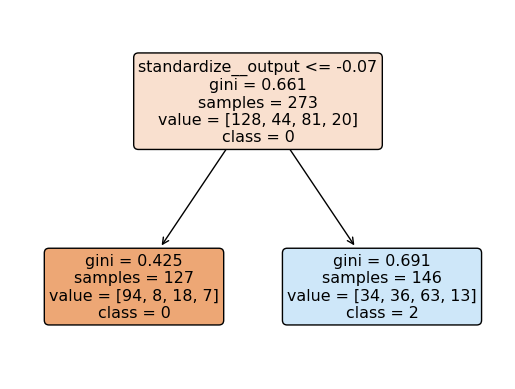

In [15]:
dt = dt_pipeline_fitted.named_steps['DecisionTree']

feature_names = dt_pipeline.named_steps['preprocessing'].get_feature_names_out()

plot_tree(dt, filled=True, feature_names = feature_names,class_names=[str(c) for c in dt.classes_],rounded=True)
plt.show()

There was only one split for this decision tree. It was based on if output was less than or equal to -0.07

In [16]:
lda_pipeline = Pipeline(
   [("preprocessing", ct),
    ("LDA", LinearDiscriminantAnalysis())]
    )

In [19]:
lda_pipeline_fitted = lda_pipeline.fit(X, y)

In [20]:
cv = cross_val_score(lda_pipeline, X, y, cv = 5, scoring = 'accuracy')
cv_lda= cv.mean()
cv_lda

0.5312457912457912

## Q2:  OvR

Create a new column in the `ha` dataset called `cp_is_3`, which is equal to `1` if the `cp` variable is equal to `3` and `0` otherwise.

Then, fit a Logistic Regression to predict this new target, and report the **F1 Score**.

Repeat for the other three `cp` categories.  Which category was the OvR approach best at distinguishing?

In [22]:
ha

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,63,1,3,145,233,0,150,1
1,37,1,2,130,250,1,187,1
2,56,1,1,120,236,1,178,1
3,57,0,0,120,354,1,163,1
4,57,1,0,140,192,1,148,1
...,...,...,...,...,...,...,...,...
268,59,1,0,164,176,0,90,0
269,57,0,0,140,241,1,123,0
270,45,1,3,110,264,1,132,0
271,68,1,0,144,193,1,141,0


In [23]:
ha['cp_is_3'] = (ha['cp']=='3').astype(int)

In [24]:
lr_pipeline = Pipeline(
  [("preprocessing", ct),
  ("LogisticRegression", LogisticRegression(penalty = 'elasticnet', solver='saga'))]
)

In [25]:
X = ha.drop(['cp', 'cp_is_3'], axis=1)
y = ha['cp_is_3']

In [ ]:
tune = {'LogisticRegression__C': [0.001,.01,.1,1,10,25,50,75, 100, 125, 150, 175, 200, 500, 1000],
           'LogisticRegression__l1_ratio': [0,.01,.2,.3,.4,.5, .75, .85, .95,1]}
gscv1 = GridSearchCV(lr_pipeline, tune, cv = 5, scoring='f1')
gscv_fitted1 = gscv1.fit(X, y)

results_df = pd.DataFrame(gscv_fitted1.cv_results_)
results_df = results_df[["param_LogisticRegression__C","param_LogisticRegression__l1_ratio",  "mean_test_score"]]

In [27]:
results_df

,param_LogisticRegression__C,param_LogisticRegression__l1_ratio,mean_test_score
0,0.001,0,0.0
1,0.001,0.01,0.0
2,0.001,0.2,0.0
3,0.001,0.3,0.0
4,0.001,0.4,0.0
...,...,...,...
145,1000,0.5,0.0
146,1000,0.75,0.0
147,1000,0.85,0.0
148,1000,0.95,0.0


In [28]:
lr_pipeline = Pipeline(
  [("preprocessing", ct),
  ("LogisticRegression", LogisticRegression(C=0.001, l1_ratio =0))]
)

In [29]:
lr_pipeline_fitted = lr_pipeline.fit(X, y)
cv = cross_val_score(lr_pipeline, X, y, cv = 5, scoring = 'f1')
cv_lr= cv.mean()
cv_lr

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is

0.0

There was an f1 score of O for category 3.

In [30]:
ha['cp_is_0'] = (ha['cp']=='0').astype(int)
X0 = ha.drop(['cp', 'cp_is_0', "cp_is_3"], axis=1)
y0 = ha['cp_is_0']

In [49]:
lr_pipeline = Pipeline(
  [("preprocessing", ct),
  ("LogisticRegression", LogisticRegression())]
)

In [ ]:
tune = {'LogisticRegression__C': [0.001,.01,.1,1,10,25,50,75, 100, 125, 150, 175, 200, 500, 1000],
           'LogisticRegression__l1_ratio': [0,.01,.2,.3,.4,.5, .75, .85, .95,1]}
gscv1 = GridSearchCV(lr_pipeline, tune, cv = 5, scoring='f1')
gscv_fitted1 = gscv1.fit(X0, y0)

results_df = pd.DataFrame(gscv_fitted1.cv_results_)
results_df = results_df[["param_LogisticRegression__C","param_LogisticRegression__l1_ratio",  "mean_test_score"]]

In [39]:
results_df.sort_values(by="mean_test_score", ascending = False)

,param_LogisticRegression__C,param_LogisticRegression__l1_ratio,mean_test_score
19,0.01,1,0.649850
10,0.01,0,0.649850
18,0.01,0.95,0.649850
17,0.01,0.85,0.649850
16,0.01,0.75,0.649850
...,...,...,...
6,0.001,0.75,0.223743
7,0.001,0.85,0.223743
8,0.001,0.95,0.223743
1,0.001,0.01,0.223743


In [40]:
lr_pipeline = Pipeline(
  [("preprocessing", ct),
  ("LogisticRegression", LogisticRegression(C=0.01, l1_ratio =1))]
)

In [41]:
lr_pipeline_fitted0 = lr_pipeline.fit(X0, y0)
cv = cross_val_score(lr_pipeline, X0, y0, cv = 5, scoring = 'f1')
cv_lr0= cv.mean()
cv_lr0

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is

0.6498501498501499

F1 score of 0.65 for category 0

In [42]:
ha['cp_is_1'] = (ha['cp']=='1').astype(int)
X1 = ha.drop(['cp', 'cp_is_1', "cp_is_3", "cp_is_0"], axis=1)
y1 = ha['cp_is_1']

In [ ]:
tune = {'LogisticRegression__C': [0.001,.01,.1,1,10,25,50,75, 100, 125, 150, 175, 200, 500, 1000],
           'LogisticRegression__l1_ratio': [0,.01,.2,.3,.4,.5, .75, .85, .95,1]}
gscv1 = GridSearchCV(lr_pipeline, tune, cv = 5, scoring='f1')
gscv_fitted1 = gscv1.fit(X1, y1)

results_df = pd.DataFrame(gscv_fitted1.cv_results_)
results_df = results_df[["param_LogisticRegression__C","param_LogisticRegression__l1_ratio",  "mean_test_score"]]

In [44]:
results_df.sort_values(by="mean_test_score", ascending = False)

,param_LogisticRegression__C,param_LogisticRegression__l1_ratio,mean_test_score
0,0.001,0,0.0
94,125,0.4,0.0
96,125,0.75,0.0
97,125,0.85,0.0
98,125,0.95,0.0
...,...,...,...
50,25,0,0.0
51,25,0.01,0.0
52,25,0.2,0.0
53,25,0.3,0.0


In [45]:
lr_pipeline_fitted1 = lr_pipeline.fit(X1, y1)
cv = cross_val_score(lr_pipeline, X1, y1, cv = 5, scoring = 'f1')
cv_lr1= cv.mean()
cv_lr1

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is

0.0

F1 score of 0 for category 1

In [46]:
ha['cp_is_2'] = (ha['cp']=='2').astype(int)
X2 = ha.drop(['cp', 'cp_is_1', "cp_is_3", "cp_is_0", "cp_is_2"], axis=1)
y2 = ha['cp_is_2']

In [ ]:
tune = {'LogisticRegression__C': [0.001,.01,.1,1,10,25,50,75, 100, 125, 150, 175, 200, 500, 1000],
           'LogisticRegression__l1_ratio': [0,.01,.2,.3,.4,.5, .75, .85, .95,1]}
gscv1 = GridSearchCV(lr_pipeline, tune, cv = 5, scoring='f1')
gscv_fitted1 = gscv1.fit(X2, y2)

results_df = pd.DataFrame(gscv_fitted1.cv_results_)
results_df = results_df[["param_LogisticRegression__C","param_LogisticRegression__l1_ratio",  "mean_test_score"]]

In [51]:
results_df.sort_values(by="mean_test_score", ascending = False)

,param_LogisticRegression__C,param_LogisticRegression__l1_ratio,mean_test_score
34,1,0.4,0.13872
30,1,0,0.13872
39,1,1,0.13872
38,1,0.95,0.13872
37,1,0.85,0.13872
...,...,...,...
17,0.01,0.85,0.00000
18,0.01,0.95,0.00000
19,0.01,1,0.00000
1,0.001,0.01,0.00000


In [52]:
lr_pipeline = Pipeline(
  [("preprocessing", ct),
  ("LogisticRegression", LogisticRegression(C=1, l1_ratio =0.4))]
)

In [53]:
lr_pipeline_fitted2 = lr_pipeline.fit(X2, y2)
cv = cross_val_score(lr_pipeline, X2, y2, cv = 5, scoring = 'f1')
cv_lr2= cv.mean()
cv_lr2

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is

0.13871956136107078

F1 score of .139 for Category 2

OvR was the best at distinguishing Category 0 with an f1 score of 0.65

## Q3: OvO

Reduce your dataset to only the `0` and `1` types of chest pain.

Then, fit a Logistic Regression to predict between the two groups, and report the **ROC-AUC**.  

Repeat comparing category `0` to `2` and `3`.  Which pair was the OvO approach best at distinguishing?

0 and 1

In [54]:
filter = ((ha['cp']=='0')| (ha['cp']=='1'))
newdf = ha[filter]
X0 = newdf.drop(['cp_is_1', 'cp_is_2', 'cp_is_3', 'cp_is_0', 'cp'], axis=1)
y0 = newdf['cp']

In [55]:
lr_pipeline_fitted0_1 = lr_pipeline.fit(X0, y0)
cv = cross_val_score(lr_pipeline_fitted0_1, X0, y0, cv = 5, scoring = 'roc_auc')
cv_lr= cv.mean()
cv_lr

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is

0.8390641025641024

0 and 2

In [56]:
filter = ((ha['cp']=='0')| (ha['cp']=='2'))
newdf = ha[filter]
X0 = newdf.drop(['cp_is_1', 'cp_is_2', 'cp_is_3', 'cp_is_0', 'cp'], axis=1)
y0 = newdf['cp']

In [57]:
lr_pipeline_fitted0_1 = lr_pipeline.fit(X0, y0)
cv = cross_val_score(lr_pipeline_fitted0_1, X0, y0, cv = 5, scoring = 'roc_auc')
cv_lr= cv.mean()
cv_lr

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is

0.7444309954751132

0 and 3

In [58]:
filter = ((ha['cp']=='0')| (ha['cp']=='3'))
newdf = ha[filter]
X0 = newdf.drop(['cp_is_1', 'cp_is_2', 'cp_is_3', 'cp_is_0', 'cp'], axis=1)
y0 = newdf['cp']

In [59]:
lr_pipeline_fitted0_1 = lr_pipeline.fit(X0, y0)
cv = cross_val_score(lr_pipeline_fitted0_1, X0, y0, cv = 5, scoring = 'roc_auc')
cv_lr= cv.mean()
cv_lr

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is

0.7331538461538462

The pair of 0 and 1 was the best with a roc auc of 0.839